# Pixel binning for NGC 309 - part1: binning the imaging data cube

In [1]:
import numpy as np
import sys, os
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

global PIXEDFIT_HOME
PIXEDFIT_HOME = os.environ['PIXEDFIT_HOME']
sys.path.insert(0, PIXEDFIT_HOME+'/src')

### Perform pixel binning to the imaging data cube using pixel_binning function in the piXedfit_bin module 

In [2]:
from piXedfit_bin import pixel_binning

flux_map_fits = "crop_fluxmap_califa_NGC309.fits"
ref_band = 4
fwhm = 4.0     ## in pixel
filters_bin = ['galex_fuv', 'galex_nuv', 'sdss_u', 'sdss_g', 'sdss_r', 'sdss_i', 
               'sdss_z', '2mass_j', '2mass_h', '2mass_k', 'wise_w1', 'wise_w2']
SNR = [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 1.0, 1.0, 1.0, 10.0, 10.0]
nbands = len(filters_bin)
    
redc_chi2_limit = 40.0/nbands
out_fits_name = "pixbin_%s" % flux_map_fits

pixbin = pixel_binning(flux_map_fits=flux_map_fits, filters=filters_bin, 
                       ref_band=ref_band, fwhm=fwhm, SNR=SNR, 
                       redc_chi2_limit=redc_chi2_limit, out_fits_name=out_fits_name)

[Pixel binning]
=> Image dimension: 131 x 131
=> Number of pixels: 8122
=> Bin index=212  number of pixels in the bin=626  cumulative number of binned pixels=8122 


### Check the FITS file produced by the pixel binning process 

In [3]:
hdu = fits.open("pixbin_crop_fluxmap_califa_NGC309.fits")
hdu.info()
header = hdu[0].header
print (header)

Filename: pixbin_crop_fluxmap_califa_NGC309.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      23   ()      
  1  BIN_FLAG      1 ImageHDU         8   (131, 131)   float64   
  2  BIN_FLUX      1 ImageHDU         9   (131, 131, 12)   float64   
  3  BIN_FLUXERR    1 ImageHDU         9   (131, 131, 12)   float64   
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  NFILTERS=                   12                                                  REFBAND =                    4                                                  Z       =            0.0188977                                                  NBINS   =                  212                                         

In [4]:
## get the maps:
bin_flag = hdu['bin_flag'].data         ### bin index
bin_flux = hdu['bin_flux'].data
bin_fluxerr = hdu['bin_fluxerr'].data
hdu.close()

### Plot the binning map

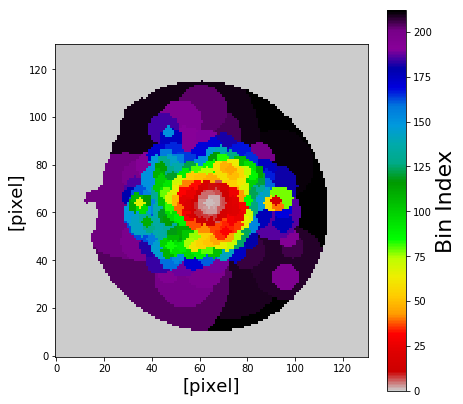

In [7]:
## plot pixel binning map:
fig1 = plt.figure(figsize=(7,7))
f1 = plt.subplot()
plt.xlabel("[pixel]", fontsize=18)
plt.ylabel("[pixel]", fontsize=18)
    
plt.imshow(bin_flag, origin='lower', cmap='nipy_spectral_r')
cb = plt.colorbar()
cb.set_label(label='Bin Index', fontsize=22)

## Demo: plot SEDs of some of the bins

In [8]:
## get the bin SEDs:
nbins_photo = int(header['nbins'])
unit = float(header['unit'])

dim_y = bin_flag.shape[0]
dim_x = bin_flag.shape[1]
#transpose photometric SEDs from (band,y,x) => (y,x,band):
bin_photo_flux_trans = np.transpose(bin_flux, axes=(1, 2, 0))*unit
bin_photo_flux_err_trans = np.transpose(bin_fluxerr, axes=(1, 2, 0))*unit

bin_photo_SED = np.zeros((nbins_photo,nbands))
bin_photo_SED_err = np.zeros((nbins_photo,nbands))

for yy in range(0,dim_y):
    for xx in range(0,dim_x):
        if bin_flag[yy][xx] > 0:
            bin_id = bin_flag[yy][xx] - 1
            bin_photo_SED[int(bin_id)] = bin_photo_flux_trans[yy][xx]
            bin_photo_SED_err[int(bin_id)] = bin_photo_flux_err_trans[yy][xx]

### Get the set of photometric filters and their central wavelengths

In [9]:
### get the set of filters:
nbands = int(header['nfilters'])
filters = []
for ii in range(0,nbands):
    str_temp = 'fil%d' % ii
    filters.append(header[str_temp])

## get the central wavelengths of the filters using cwave_filters function from filtering module
from filtering import cwave_filters

photo_wave = cwave_filters(filters)

### Plot first 50 bins

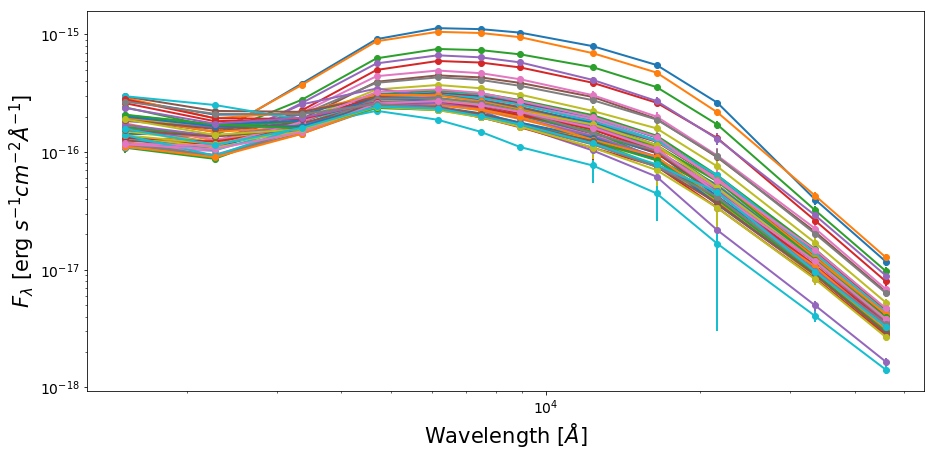

In [15]:
fig1 = plt.figure(figsize=(15,7))
f1 = plt.subplot()   
f1.set_yscale('log')
f1.set_xscale('log')
plt.setp(f1.get_yticklabels(), fontsize=14)
plt.setp(f1.get_xticklabels(), fontsize=14)
plt.xlabel(r'Wavelength $[\AA]$', fontsize=21)
plt.ylabel(r'$F_{\lambda}$ [erg $s^{-1}cm^{-2}\AA^{-1}$]', fontsize=21)

for ii in range(0,50):
    plt.errorbar(photo_wave, bin_photo_SED[ii], yerr=bin_photo_SED_err[ii], fmt='-o', lw=2)